In [3]:
import os
import glob
import time

import numpy as np
import pandas as pd
#IPython.display for audio output
import IPython.display as ipd
# Librosa for audio
import librosa
import librosa.display
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

# For designing the band-pass filter
from scipy.signal import butter, lfilter, hilbert

import matplotlib.pyplot as plt
import matplotlib.style as ms
import matplotlib.ticker as ticker
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

In [4]:
def butter_bandpass_filter(data, lowcut=500, highcut=1500, fs=8000, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq

    b, a = butter(order, [low, high], btype='band')
    y = lfilter(b, a, data)
    return y

In [5]:
fn = '../Emergency-Vehicle-Detection/Data/balanced/cleaned_emergency/1.wav'
y, sr = librosa.load(fn, sr=8000)
ipd.Audio(fn)

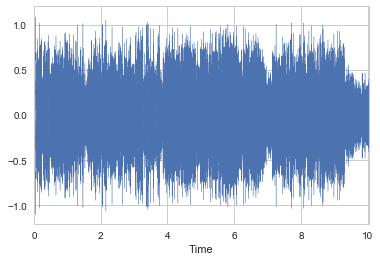

In [6]:
librosa.display.waveplot(y=y, sr=sr);

In [7]:
y_filt = butter_bandpass_filter(y)

In [8]:
def melspectrogram(y,sr):
    # Let's make and display a mel-scaled power (energy-squared) spectrogram
    S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)

    # Convert to log scale (dB). We'll use the peak power (max) as reference.
    log_S = librosa.power_to_db(S, ref=np.max)
    
    return log_S

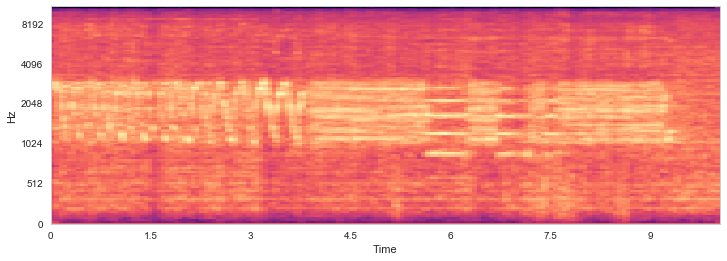

In [9]:
log_S = melspectrogram(y,sr)
# Make a new figure
plt.figure(figsize=(12,4))
# Display the spectrogram on a mel scale
# sample rate and hop length parameters are used to render the time axis
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel');

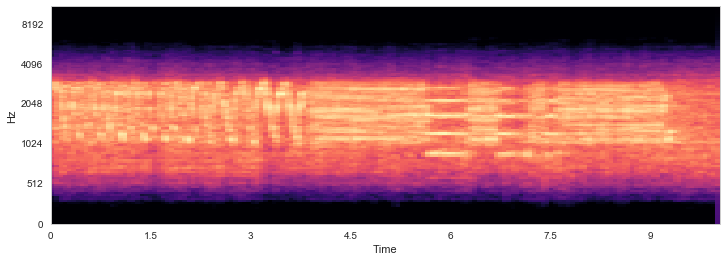

In [10]:
log_S = melspectrogram(y_filt,sr)
# Make a new figure
plt.figure(figsize=(12,4))
# Display the spectrogram on a mel scale
# sample rate and hop length parameters are used to render the time axis
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel');

In [11]:
analytic_signal = hilbert(y_filt)
amplitude_envelope = np.abs(analytic_signal)

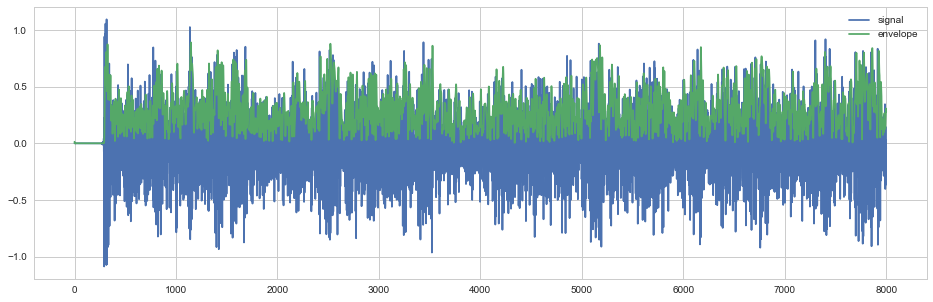

In [12]:
t = np.arange(len(y[:8000])) / sr
fig = plt.figure(figsize=(16,5))
ax0 = fig.add_subplot(111)
ax0.plot(y[:8000], label='signal')
ax0.plot(amplitude_envelope[:8000], label='envelope')
ax0.legend();

## Feature Extraction

In [13]:
from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import audioFeatureExtraction

100%|██████████| 123/123 [02:34<00:00,  3.14s/it]


In [14]:
def preprocess(y):
    y_filt = butter_bandpass_filter(y)
    analytic_signal = hilbert(y_filt)
    amplitude_envelope = np.abs(analytic_signal)
    return amplitude_envelope

In [15]:
# Read all the files from the dataset folder
path_em = '../Emergency-Vehicle-Detection/Data/balanced/cleaned_emergency/'
path_nonem = '../Emergency-Vehicle-Detection/Data/balanced/nonEmergency/'

em_files = glob.glob(os.path.join(path_em, '*.wav'))
nonem_files = glob.glob(os.path.join(path_nonem, '*.wav'))

In [16]:
X_em = []
for fn in tqdm(em_files):
    y, sr = librosa.load(fn, sr=8000)
    y = preprocess(y)
    features = audioFeatureExtraction.stFeatureExtraction(y, sr, 0.10*sr, .05*sr)
    X_em.extend(features)

In [16]:
len(X_em)

20924

In [17]:
len(X_em[0])

34

In [18]:
count = 0
X_nonem = []
for fn in tqdm(nonem_files):
    y, sr = librosa.load(fn, sr=8000)
    y = preprocess(y)
    features = audioFeatureExtraction.stFeatureExtraction(y, sr, 0.10*sr, .05*sr);
    X_nonem.extend(features)
    count += 1
    if count == 120:
        break

In [19]:
len(X_nonem)

23519

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

def prepare_data(X_em, X_nonem):
    X_em = np.array(X_em)
    X_nonem = np.array(X_nonem)
    
    X = np.vstack((X_em, X_nonem))
    Y = np.hstack((np.ones(len(X_em)), np.zeros(len(X_nonem))))
    
    scaler = StandardScaler()
    scaler.fit_transform(X)
    
    X, Y = shuffle(X, Y, random_state=7)
    
#     X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    
    return X, Y, scaler

In [21]:
X_train, Y_train, scaler1 = prepare_data(X_em, X_nonem)

In [22]:
f= open("scaler_values.txt","w+")
mean_v = []
std_v = []
for i in range(len(scaler1.mean_)):
    mean_v.append(scaler1.mean_[i])
    std_v.append(scaler1.scale_[i])
f.write("scaler mean:\n{}".format(mean_v))
f.write("\nscaler std:\n{}".format(std_v))
f.close()

In [26]:
test_path_em = '../Emergency-Vehicle-Detection/Data/new_eval/cleaned_emergency/'
test_path_nonem = '../Emergency-Vehicle-Detection/Data/eval/nonEmergency/'

test_em_files = glob.glob(os.path.join(test_path_em, '*.wav'))
test_nonem_files = glob.glob(os.path.join(test_path_nonem, '*.wav'))

In [27]:
X_test_em = []
for fn in tqdm(test_em_files):
    y, sr = librosa.load(fn, sr=8000)
    y = preprocess(y)
    features = audioFeatureExtraction.stFeatureExtraction(y, sr, 0.10*sr, .05*sr);
    X_test_em.extend(features)

In [28]:
X_test_nonem = []
for fn in tqdm(test_nonem_files):
    y, sr = librosa.load(fn, sr=8000)
    y = preprocess(y)
    features = audioFeatureExtraction.stFeatureExtraction(y, sr, 0.10*sr, .05*sr);
    X_test_nonem.extend(features)

In [29]:
X_test, Y_test, scaler2 = prepare_data(X_test_em, X_test_nonem)

In [30]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.models import load_model
import tensorflow as tf
from keras import backend as K
K.set_image_dim_ordering('th')

# fix random seed for reproducibility
np.random.seed(7)

# Supress Tensorflow error logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [31]:
model = Sequential()
model.add(Dense(34, input_dim=34, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

In [32]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, verbose=0, mode='auto')
callbacks_list = [earlystop]

In [33]:
history = model.fit(X_train, Y_train, epochs=200, validation_data=(X_test, Y_test), batch_size=512, callbacks=callbacks_list)
model.save("model_3h.h5")
print("Saved model to disk!")

In [34]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.savefig('model_history.png')

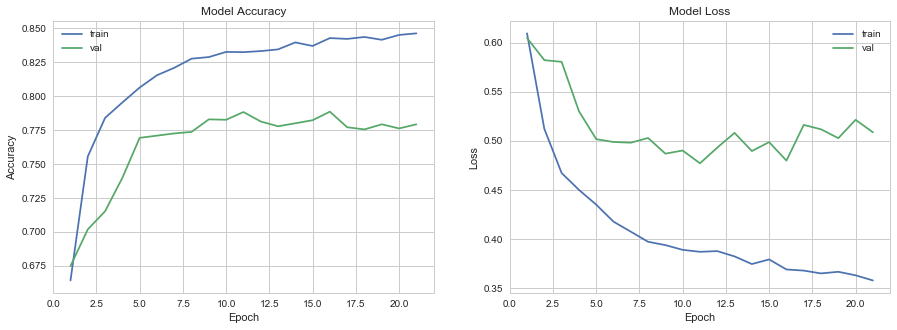

In [35]:
plot_model_history(history)

In [36]:
model = load_model('model_3h.h5')

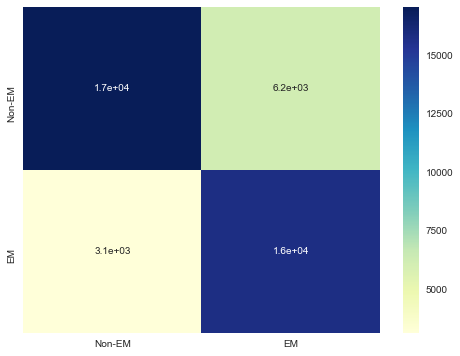

In [37]:
Y_pred = model.predict_classes(X_test)
cm = confusion_matrix(Y_pred, Y_test)
df_cm = pd.DataFrame(cm, index = ['Non-EM', 'EM'],
                  columns = ['Non-EM', 'EM'])
plt.figure(figsize = (8,6))
sns.heatmap(df_cm, annot=True, cmap='YlGnBu');

In [38]:
def predict_op(y, scaler):
    y = preprocess(y)
    features_list = audioFeatureExtraction.stFeatureExtraction(y, sr, 0.10*sr, .05*sr)
    scaler.transform(features_list)
    count = 0
    N = 10
    th = 0.5
    
    prob_list = []
    class_list = []
    for i in range(N):
        p = model.predict(features_list[i].reshape(1,34), batch_size=None, verbose=0)
        p = p.flatten()
        prob_list.append(p)
    prob = np.mean(prob_list)
    #print(prob)
    if prob > th:
        #print("Em")
        class_list.append(1)
    else:
        #print("Non-em")
        class_list.append(0)
    
    for i in range(N,len(features_list)):
        prob_list.pop(0)
        p = model.predict(features_list[i].reshape(1,34), batch_size=None, verbose=0)
        p = p.flatten()
        prob_list.append(p)
        prob = np.mean(prob_list)
        #print(prob)
        if prob > th:
            #print("Em")
            class_list.append(1)
        else:
            #print("Non-em")
            class_list.append(0)
    if np.mean(class_list) > 0.5:
        return 1
    else:
        return 0

In [39]:
test_path_em = '../Emergency-Vehicle-Detection/Data/new_eval/cleaned_emergency/'
test_path_nonem = '../Emergency-Vehicle-Detection/Data/eval/nonEmergency/'

test_em_files = glob.glob(os.path.join(test_path_em, '*.wav'))
test_nonem_files = glob.glob(os.path.join(test_path_nonem, '*.wav'))

tot = 0
correct_em = 0
op_list = []
for test_file in tqdm(test_em_files):
    y, sr = librosa.load(test_file, sr=8000)
    classes = predict_op(y, scaler2)
    if classes == 1:
        correct_em += 1
    tot += 1

In [40]:
correct_em

107

In [41]:
tot

134

In [42]:
tot = 0
correct_nonem = 0
op_list = []
for test_file in tqdm(test_nonem_files):
    y, sr = librosa.load(test_file, sr=8000)
    classes = predict_op(y, scaler2)
    if classes == 0:
        correct_nonem += 1
    tot += 1

In [43]:
tot

105

In [44]:
correct_nonem

100

In [158]:
test_file = '../Emergency-Vehicle-Detection/Data/new_eval/cleaned_emergency/24.wav'
y, sr = librosa.load(test_file, sr=8000)
ipd.Audio(test_file)

FP: 104 (bicycle bell)  
FN: 12 (clear siren), 15 (vehicle noise)

In [159]:
def predict_prob(y, scaler):
    y = preprocess(y)
    mfccs_list = audioFeatureExtraction.stFeatureExtraction(y, sr, 0.10*sr, .05*sr)
    scaler.transform(mfccs_list)
    count = 0
    N = 20
    th = 0.5
    
    model = load_model('model_3h.h5')
    
    prob_list = []
    class_list = []
    for i in range(N):
        p = model.predict(mfccs_list[i].reshape(1,34), batch_size=None, verbose=0)
        p = p.flatten()
        prob_list.append(p)
    prob = np.mean(prob_list)
    #print(prob)
    if prob > th:
        #print("Em")
        class_list.append(1)
    else:
        #print("Non-em")
        class_list.append(0)
    
    for i in range(N,len(mfccs_list)):
        prob_list.pop(0)
        p = model.predict(mfccs_list[i].reshape(1,34), batch_size=None, verbose=0)
        p = p.flatten()
        prob_list.append(p)
        prob = np.mean(prob_list)
        #print(prob)
        if prob > th:
            #print("Em")
            class_list.append(1)
        else:
            #print("Non-em")
            class_list.append(0)
    return class_list

In [160]:
classes = predict_prob(y, scaler2)

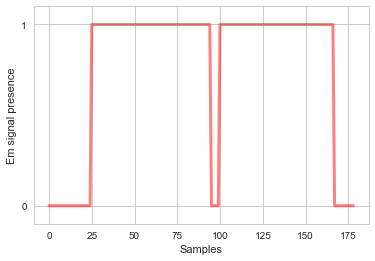

In [161]:
plt.figure()
plt.plot(classes, c='r', linewidth = 3.0, alpha=0.5)
plt.yticks([0,1])
plt.ylim([-0.1,1.1])
plt.xlabel("Samples")
plt.ylabel("Em signal presence")
plt.grid('on')
plt.show()

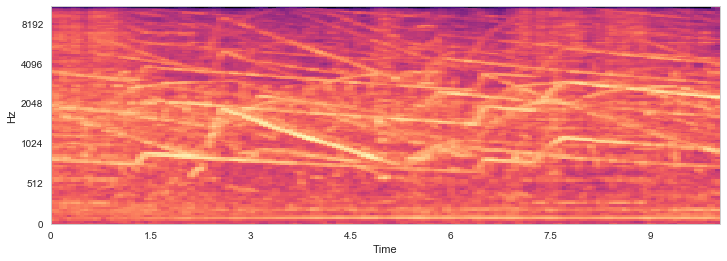

In [162]:
log_S = melspectrogram(y,sr)
# Make a new figure
plt.figure(figsize=(12,4))
# Display the spectrogram on a mel scale
# sample rate and hop length parameters are used to render the time axis
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel');